In [1]:
import csv
import json
import requests
import pprint

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans

%matplotlib inline

pd.set_option('display.max_columns', None)
data = pd.read_csv('data/new_client_data.csv', header=[0,1], index_col=0)
# data1 = pd.read_csv('data/sortby_MAC_Time_2019.csv', header=[0,1], index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
data.head(2)

,l1,AP,AP.1,AP.2,AP.3,Association Time,Association Time.1,Association Time.2,Association Time.3,Association Time.4,Association Time.5,Client,Client.1,Client.2,Client.3,Client.4,Client.5,Client.6,Client.7,Client.8,Client.9,Client.10,Client.11,Client.12,Disassociation Time,Disassociation Time.1,Disassociation Time.2,Disassociation Time.3,Disassociation Time.4,Disassociation Time.5,Session Duration,Session Duration.1,Session Duration.2,Session Duration.3,Utilization,Utilization.1,Utilization.2,Utilization.3,Utilization.4,Utilization.5,Utilization.6,Utilization.7,Utilization.8
0,l2,IP Address,MAC Address,Map Location,Name,day,hour,minute,month,second,year,Association ID,Authentication,EAP Type,Encryption Cipher,Endpoint Type,IP Address,MAC Address,Policy Type,Protocol,Radio Type,SSID,Type,VLAN ID,day,hour,minute,month,second,year,days,hours,minutes,seconds,Avg. Session Throughput (Kbps),Bytes Received,Bytes Sent,Data Retries,Packets Received,Packets Sent,RSSI (dBm),RTS Retries,SNR (dB)
1,0,164.125.168.230,84:3d:c6:e6:51:20,Pusan > GunSul (401) > GunSul1F,16AP-401-1-1,30,18,2,7,1,2019,2,Yes,PEAP,CCMP (AES),none,164.125.248.215,0,WPA2,802.11n(5GHz),802.11a/n/ac,PNU-WiFi,Unified Wireless,19,30,18,7,7,2,2019,0,0,5,1,<0.1,0,0,0,0,0,-78,0,17
2,1,164.125.168.230,84:3d:c6:e6:51:20,Pusan > GunSul (401) > GunSul1F,16AP-401-1-1,29,12,16,7,31,2019,1,Yes,PEAP,CCMP (AES),Linux-Workstation,172.21.27.89,1,WPA2,802.11ac,802.11a/n/ac,PNU-WiFi,Unified Wireless,17,29,12,26,7,32,2019,0,0,10,1,<0.1,0,0,0,0,0,-128,0,0


# 1. 데이터 정리

## 칼럼 정리

In [3]:
dic = {}
for col1, col2 in data.columns:
    if col1!= 'l1':
        dic[col1] = ''
        strs = col1.split('.')
        dic[col1] = strs[0]

data.rename(columns = dic, inplace = True)

# 장전캠퍼스만

In [4]:
data = data[data[('AP','Map Location')].str.startswith('Pusan')]

## Session Duration 합치기

In [5]:
seconds = data[('Session Duration', 'days')]*24*60*60 + data[('Session Duration', 'hours')]*60*60 + data[('Session Duration', 'minutes')]*60 + data[('Session Duration', 'seconds')]
data[('Sum of Session Duration', 'seconds')] = seconds

In [6]:
data.drop([('Session Duration', 'days'),('Session Duration', 'hours'),('Session Duration', 'minutes'),('Session Duration', 'seconds')], axis=1, inplace=True)


In [7]:
data[data[('Utilization','Avg. Session Throughput (Kbps)')] == '<0.1']

l1               AP                     \
0             l2       IP Address        MAC Address   
1              0  164.125.168.230  84:3d:c6:e6:51:20   
2              1  164.125.168.230  84:3d:c6:e6:51:20   
3              2  164.125.168.230  84:3d:c6:e6:51:20   
4              3  164.125.168.230  84:3d:c6:e6:51:20   
5              4  164.125.168.230  84:3d:c6:e6:51:20   
...          ...              ...                ...   
8385343  8385342   164.125.58.248  a0:e0:af:e3:ee:b0   
8385344  8385343   164.125.58.248  a0:e0:af:e3:ee:b0   
8385345  8385344   164.125.58.248  a0:e0:af:e3:ee:b0   
8385346  8385345   164.125.58.248  a0:e0:af:e3:ee:b0   
8385347  8385346   164.125.58.248  a0:e0:af:e3:ee:b0   

                                                       Association Time       \
0                           Map Location          Name              day hour   
1        Pusan > GunSul (401) > GunSul1F  16AP-401-1-1               30   18   
2        Pusan > GunSul (401) > GunSul1F  16AP-401-1-1               29   12   
3        Pusan > GunSul (401) > GunSul1F  16AP-401-1-1               30   19   
4        Pusan > GunSul (401) > GunSul1F  16AP-401-1-1               29   18   
5        Pusan > GunSul (401) > GunSul1F  16AP-401-1-1               29    9   
...                                  ...           ...              ...  ...   
8385343        Pusan > Silhum (111) > 2F  17AP-111-2-1                4   14   
8385344        Pusan > Silhum (111) > 2F  17AP-111-2-1                7   10   
8385345        Pusan > Silhum (111) > 2F  17AP-111-2-1                6   12   
8385346        Pusan > Silhum (111) > 2F  17AP-111-2-1                7   16   
8385347        Pusan > Silhum (111) > 2F  17AP-111-2-1                4    8   

                                          Client                          \
0       minute month second  year Association ID Authentication EAP Type   
1            2     7      1  2019              2            Yes     PEAP   
2           16     7     31  2019              1            Yes     PEAP   
3           27     7     45  2019              1            Yes     PEAP   
4            8     7      6  2019              4            Yes     TTLS   
5            0     7     43  2019              1            Yes     PEAP   
...        ...   ...    ...   ...            ...            ...      ...   
8385343     32     5     49  2020              1            Yes     PEAP   
8385344     37     5     17  2020              1            Yes     PEAP   
8385345     34     5     36  2020              1            Yes     PEAP   
8385346     24     5      4  2020              1            Yes     PEAP   
8385347     15     5     51  2020              1            Yes     TTLS   

                                                                          \
0       Encryption Cipher                 Endpoint Type       IP Address   
1              CCMP (AES)                          none  164.125.248.215   
2              CCMP (AES)             Linux-Workstation     172.21.27.89   
3              CCMP (AES)             Linux-Workstation     172.21.27.89   
4              CCMP (AES)                     iPhone 7+    172.21.58.116   
5              CCMP (AES)                       Android     172.21.17.10   
...                   ...                           ...              ...   
8385343        CCMP (AES)             Linux-Workstation      172.21.4.74   
8385344        CCMP (AES)  Android-Samsung-Galaxy-Phone     172.21.37.58   
8385345        CCMP (AES)             Linux-Workstation  164.125.248.109   
8385346        CCMP (AES)                       Android    172.21.33.105   
8385347        CCMP (AES)                    iPhone12,1  164.125.251.224   

                                                                          \
0       MAC Address Policy Type         Protocol    Radio Type      SSID   
1                 0        WPA2    802.11n(5GHz)  802.11a/n/ac  PNU-WiFi   
2                 1        WPA2       

# Disassociation Time , Association Time

In [8]:
date = data[[('Association Time','year'),('Association Time','month'),('Association Time','day')]].apply(lambda x : '-'.join("0"+str(v) if v<10 else str(v) for v in x), axis = 1)
time = data[[('Association Time','hour'),('Association Time','minute'),('Association Time','second')]].apply(lambda x : ':'.join("0"+str(v) if v<10 else str(v) for v in x), axis = 1)
data[('Association Time', 'time')] = date + " " + time


In [9]:
date = data[[('Disassociation Time','year'),('Disassociation Time','month'),('Disassociation Time','day')]].apply(lambda x : '-'.join("0"+str(v) if v<10 else str(v) for v in x), axis = 1)
time = data[[('Disassociation Time','hour'),('Disassociation Time','minute'),('Disassociation Time','second')]].apply(lambda x : ':'.join("0"+str(v) if v<10 else str(v) for v in x), axis = 1)
data[('Disassociation Time', 'time')] = date + " " + time


# Avg. Session Throughput (Kbps) 의 string -> float

In [10]:
data[('Utilization','Avg. Session Throughput (Kbps)')] = data[('Utilization','Avg. Session Throughput (Kbps)')].str.replace(',',"")

In [11]:
# <0.1
in_str = data[('Utilization','Avg. Session Throughput (Kbps)')]=='<0.1'
data.loc[in_str,('Utilization','Avg. Session Throughput (Kbps)')] = '0.05'

In [12]:
(data[('Utilization','Avg. Session Throughput (Kbps)')]=='<0.1').sum()


0

In [13]:
(data[('Utilization','Avg. Session Throughput (Kbps)')].str.contains(',')).sum()

0

In [14]:
data[('Utilization','Avg. Session Throughput (Kbps)')] = data[('Utilization','Avg. Session Throughput (Kbps)')].astype(float)


In [15]:
data.drop([('Association Time','year'),('Association Time','month'),('Association Time','day'),('Association Time','hour'),('Association Time','minute'),('Association Time','second')], axis=1, inplace=True)
data.drop([('Disassociation Time','year'),('Disassociation Time','month'),('Disassociation Time','day'),('Disassociation Time','hour'),('Disassociation Time','minute'),('Disassociation Time','second')], axis=1, inplace=True)
data.drop([('Client','Authentication')], axis=1, inplace=True)


# ('AP','Building Num') 건물 넘버 칼럼 추가

In [16]:
# 사용이 가장 많은 건물 중에서 스루풋이 가장 낮은 건물
# Session Duration에 차이가 있는 건물
data[('AP','Building Num')] = '0'
location = data[('AP','Map Location')]
dic = {}
idx=[]
num=[]
for index, loc_data in zip(location.index,location):
    
    line = loc_data.split(')')[0]
    loc_num = line[-3:]
    
    idx.append(index)
    num.append(loc_num)

dic['idx'] = idx
dic['num'] = num

In [17]:
building = pd.DataFrame(dic)
building = building.set_index("idx")
data[('AP','Building Num')] = building['num']

In [18]:
original = data[(data[('Utilization','Bytes Received')] != 0) &(data[('Utilization','Bytes Sent')] != 0)]
data = data[(data[('Utilization','Bytes Received')] != 0) &(data[('Utilization','Bytes Sent')] != 0)]

# 2020년 이전

In [19]:
data = data[data[('Association Time','time')] < '2020-01-01']

# 2. 전체로 주기있는 칼럼 찾아내기

## 2-1) 문자데이터

In [20]:
myday = pd.to_datetime(data[('Disassociation Time', 'time')])
data[('Day Of Week', 'day')] = myday.dt.day_name()

In [21]:
## dic = 그 날짜, 시간에 연결된 클라이언트의 index번호

In [22]:
def num_in_every_hour(col1, col2, eap):
    
    val = data[data[col1,col2] == eap]
    
    date = []
    yoil = []
    hour = []
    
    dic = {}
    
    i =0
    for time1,time2 in zip( pd.to_datetime(val[('Association Time', 'time')]), pd.to_datetime(val[('Disassociation Time', 'time')])  ):
        t1 = time1.hour 
        t2 = time2.hour #정확하게 associ 와 disassoci 의 차이를 통해

        for t in range(t1, t2+1):
            
            if t < 10:
                t = '0'+str(t)
            else: t = str(t)

            #secific_date
            
            d = time1.date()
            h = t
            
            secific_date =str(d)+" " +str(h)
            
            if secific_date in dic:
                dic[secific_date] = dic[secific_date]+1
            else:
                dic[secific_date] = 1
        
#         totaltry = (data.shape[0])/10000
#         persent = str(i/totaltry*100) + "%"
#         if i%10000 == 0:
#             print(i, totaltry, persent)
#         i+=1
                    
    return dic


## 1) EAP타입 

In [23]:
exp_df=data

In [24]:
data[('Client','EAP Type')].unique()

array(['PEAP', 'TTLS', 'Not Available', 'Unknown', 'EAP TLS', 'LEAP'],
      dtype=object)

In [25]:
data[('Client','EAP Type')].value_counts()

TTLS             1795161
PEAP             1401066
Not Available       7792
EAP TLS              150
Unknown               28
LEAP                  19
Name: (Client, EAP Type), dtype: int64

In [26]:
def change_to_df(col1, col2, yoso_name):
    
    #몇시에 몇개있는지 함수 실행 - 딕셔너리 리턴
    res = num_in_every_hour(col1, col2, yoso_name)
    
    #딕셔너리 키(날짜-시간)로 소팅
    sorted_res = sorted(res.items())
    
    date = []
    yoil = []
    hour = []
    df = []
    
    #첫날, 마지막날
    firstday = "2019-05-19"
    lastday = "2019-12-31"

    daterange = pd.date_range(start = firstday, end = lastday)
    hourrange = ["0"+str(x)  if x < 10 else str(x) for x in range(0,24)]

    for d in daterange:
        for h in hourrange:
            each_day = str(d.date()) + " " + str(h)
            if each_day in res:
                date.append(str(d.date()))
                yoil.append(d.day_name())
                hour.append(h)
                df.append(res[each_day])
            else:
                date.append(str(d.date()))
                yoil.append(d.day_name())
                hour.append(h)
                df.append(0)
        
    series = pd.Series(df,index = [date,yoil,hour])
    ret_df = pd.DataFrame(series)
    
    ret_df.index.names = ["date",'yoil',"hour"]
    ret_df.columns = [yoso_name]
   
    return ret_df

In [27]:
peap = change_to_df('Client','EAP Type','PEAP')
ttls = change_to_df('Client','EAP Type','TTLS')
not_available = change_to_df('Client','EAP Type','Not Available')
unknown = change_to_df('Client','EAP Type','Unknown')
eap_tls = change_to_df('Client','EAP Type','EAP TLS')
leap = change_to_df('Client','EAP Type','LEAP')

In [28]:
peap

PEAP
date       yoil    hour      
2019-05-19 Sunday  00      79
                   01      67
                   02      56
                   03      51
                   04      44
...                       ...
2019-12-31 Tuesday 19     441
                   20     355
                   21     280
                   22     208
                   23     112

[5448 rows x 1 columns]

In [29]:
def change_to_month(yoso_df):
    month=[]
    yoil=[]
    hour=[]
    df=[]
    for monthNum in range(5,13):
        m=""
        d=30

        # 월에 10보다작으면 0붙이기
        if monthNum <10:
            m = "0"+str(monthNum)
        else:
            m = str(monthNum)

        #5,7,8,10,12,월은 31일까지있음
        if monthNum in [5,7,8,10,12]:
            d = 31

       #5월은 19일부터시작
        if monthNum==5:
            firstday = "2019-" + m+"-19"
        else:
            firstday = "2019-" + m+"-01"

        lastday = "2019-"+m+"-"+str(d)

        hourrange = ["0"+str(x)  if x < 10 else str(x) for x in range(0,24)]
        daterange = pd.date_range(start = firstday, end = lastday)
        weeks = ["Sunday","Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday"]



        for week in weeks:
            hcnt = {}
            hdiv = {}
            for d in daterange:

                if d.day_name() == week:
                    for h in hourrange:

                        if h in hcnt:
                            hcnt[h]+= yoso_df.loc[(str(d.date()),week,h),:][0]
                        else:
                            hcnt[h] = yoso_df.loc[(str(d.date()),week,h),:][0]

                        if h in hdiv:
                            hdiv[h]+= 1
                        else:
                            hdiv[h] = 1


            #나누기 평균
            for k1,k2 in zip(hcnt,hdiv):
                hcnt[k1] = hcnt[k1]/hdiv[k2]

            #원소붙이기
            for k in hcnt:
                hour.append(k)
                df.append(hcnt[k])
                yoil.append(week)
                month.append(monthNum)


    series = pd.Series(df,index = [month,yoil,hour])
    ret_df = pd.DataFrame(series)    

    ret_df.index.names = ["month",'yoil',"hour"]
    ret_df.columns = [yoso_df.columns[0]]

    return ret_df
        

그래프 그리기

In [30]:
total_eap = pd.concat([peap,ttls,not_available, unknown,eap_tls, leap ], axis=1)

In [31]:
total_eap_temp = total_eap.reset_index()

In [32]:
total_eap_temp.drop(['date','yoil','hour'], axis=1, inplace=True)

그래프

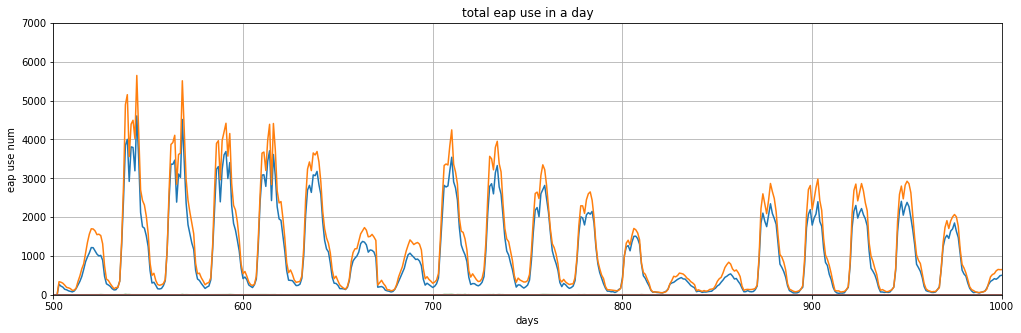

In [33]:
plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,7000)
plt.xlim(500,1000)
plt.plot(total_eap_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

달마다 평균내기

In [34]:
peap_yoil = change_to_month(peap)
ttls_yoil = change_to_month(ttls)
not_available_yoil = change_to_month(not_available)
unknown_yoil = change_to_month(unknown)
eap_tls_yoil = change_to_month(eap_tls)
leap_yoil = change_to_month(leap)

In [35]:
total_yoil = pd.concat([peap_yoil,ttls_yoil,not_available_yoil, unknown_yoil, eap_tls_yoil,leap_yoil ], axis=1)

In [36]:
total_yoil_temp = total_yoil.reset_index()

In [37]:
total_yoil_temp.drop(['month','yoil','hour'], axis=1, inplace=True)

In [38]:
total_yoil_temp

,PEAP,TTLS,Not Available,Unknown,EAP TLS,LEAP
0,82.00,99.50,0.00,0.0,0.0,0.0
1,56.00,81.50,0.00,0.0,0.0,0.0
2,46.50,74.50,0.00,0.0,0.0,0.0
3,38.50,71.50,0.00,0.0,0.0,0.0
4,33.00,57.00,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...
1339,6.50,21.25,0.50,0.0,0.0,0.0
1340,8.25,17.00,0.25,0.0,0.0,0.0
1341,8.75,13.25,0.25,0.0,0.0,0.0
1342,10.25,17.25,0.25,0.0,0.0,0.0


그래프 그리기

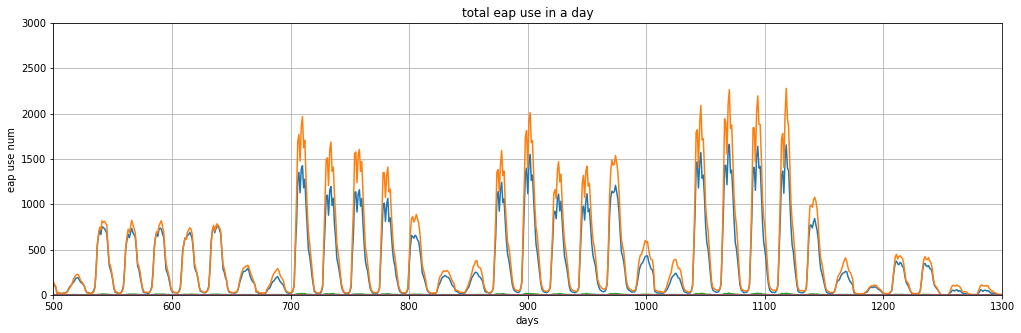

In [39]:
plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,3000)
plt.xlim(500,1300)
plt.plot(total_yoil_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

## 2) Encryption Cipher

In [40]:
data[('Client','Encryption Cipher')].unique()

array(['CCMP (AES)', 'TKIP-MIC', 'None', 'WEP (104 bits)'], dtype=object)

In [41]:
data[('Client','Encryption Cipher')].value_counts()

CCMP (AES)        3203990
TKIP-MIC              171
None                   28
WEP (104 bits)         27
Name: (Client, Encryption Cipher), dtype: int64

In [42]:
ccmp = change_to_df('Client','Encryption Cipher','CCMP (AES)')
tkip = change_to_df('Client','Encryption Cipher','TKIP-MIC')
none = change_to_df('Client','Encryption Cipher','None')
wep = change_to_df('Client','Encryption Cipher','WEP (104 bits)')

In [43]:
ccmp_yoil = change_to_month(ccmp)
tkip_yoil = change_to_month(tkip)
none_yoil = change_to_month(none)
wep_yoil = change_to_month(wep)


In [44]:
total_yoil = pd.concat([ccmp_yoil,tkip_yoil,none_yoil, wep_yoil], axis=1)

In [45]:
total_yoil_temp = total_yoil.reset_index()

In [46]:
total_yoil_temp.drop(['month','yoil','hour'], axis=1, inplace=True)

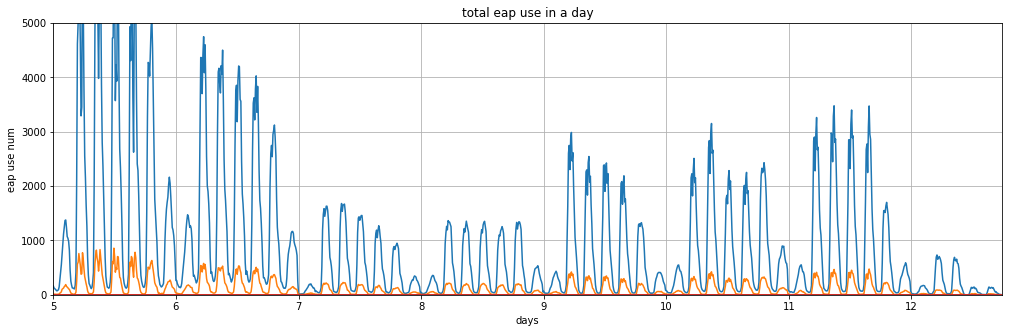

In [358]:
plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,5000)
plt.xlim(500,1300)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(total_yoil_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

## 3) Policy type

In [48]:
data[('Client','Policy Type')].unique()

array(['WPA2', 'WPA1', 'NOTAVAILABLE'], dtype=object)

In [49]:
data[('Client','Policy Type')].value_counts()

WPA2            3203511
WPA1                650
NOTAVAILABLE         55
Name: (Client, Policy Type), dtype: int64

In [50]:
wap2 = change_to_df('Client','Policy Type','WPA2')
wap1 = change_to_df('Client','Policy Type','WPA1')
notavailable = change_to_df('Client','Policy Type','NOTAVAILABLE')

In [51]:
wap2_yoil = change_to_month(wap2)
wap1_yoil = change_to_month(wap1)
notavailable_yoil = change_to_month(notavailable)


In [52]:
total_yoil = pd.concat([wap2_yoil,wap1_yoil,notavailable_yoil], axis=1)

In [53]:
total_yoil_temp = total_yoil.reset_index()

In [54]:
total_yoil_temp.drop(['month','yoil','hour'], axis=1, inplace=True)

In [ ]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,7000)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(total_yoil_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

## 4) Protocol

In [56]:
data[('Client','Protocol')].unique()

array(['802.11ac', '802.11n(2.4GHz)', '802.11n(5GHz)', '802.11a',
       '802.11g'], dtype=object)

In [57]:
data[('Client','Protocol')].value_counts()

802.11n(2.4GHz)    1574049
802.11n(5GHz)       942505
802.11ac            686841
802.11g                708
802.11a                113
Name: (Client, Protocol), dtype: int64

In [58]:
p1 = change_to_df('Client','Protocol','802.11ac')
p2 = change_to_df('Client','Protocol','802.11n(2.4GHz)')
p3 = change_to_df('Client','Protocol','802.11n(5GHz)')
p4 = change_to_df('Client','Protocol','802.11a')
p5 = change_to_df('Client','Protocol','802.11g')

In [59]:
p1_yoil = change_to_month(p1)
p2_yoil = change_to_month(p2)
p3_yoil = change_to_month(p3)
p4_yoil = change_to_month(p4)
p5_yoil = change_to_month(p5)


In [60]:
total_yoil = pd.concat([p1_yoil,p2_yoil,p3_yoil,p4_yoil,p5_yoil], axis=1)

In [61]:
total_yoil_temp = total_yoil.reset_index()

In [62]:
total_yoil_temp.drop(['month','yoil','hour'], axis=1, inplace=True)

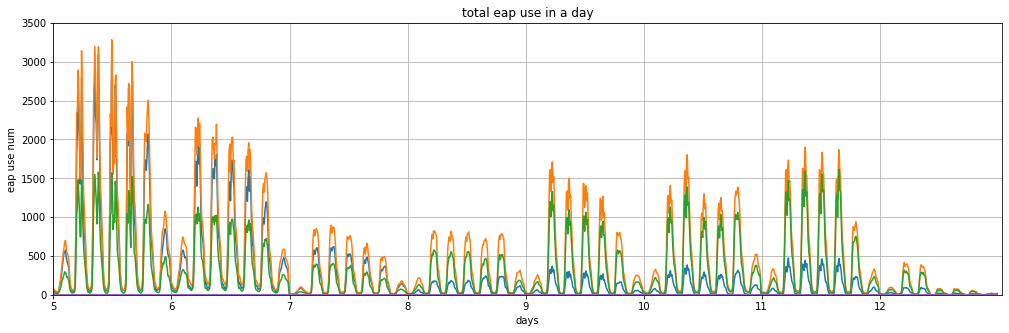

In [63]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,3500)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(total_yoil_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

## 4) Radio Type

In [64]:
data[('Client','Radio Type')].unique()

array(['802.11a/n/ac', '802.11b/g/n', '802.11a/n'], dtype=object)

In [65]:
data[('Client','Radio Type')].value_counts()

802.11b/g/n     1574739
802.11a/n        908505
802.11a/n/ac     720972
Name: (Client, Radio Type), dtype: int64

In [66]:
r1 = change_to_df('Client','Radio Type','802.11b/g/n')
r2 = change_to_df('Client','Radio Type','802.11a/n')
r3 = change_to_df('Client','Radio Type','802.11a/n/ac')

In [67]:
r1_yoil = change_to_month(r1)
r2_yoil = change_to_month(r2)
r3_yoil = change_to_month(r3)


In [68]:
total_yoil = pd.concat([r1_yoil,r2_yoil,r3_yoil], axis=1)

In [69]:
total_yoil_temp = total_yoil.reset_index()

In [70]:
total_yoil_temp.drop(['month','yoil','hour'], axis=1, inplace=True)

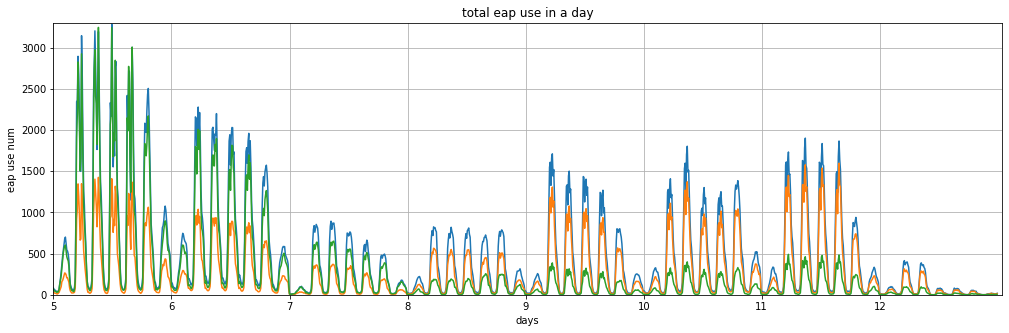

In [71]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,3300)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(total_yoil_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

## 5) SSID

In [72]:
data[('Client','SSID')].unique()

array(['PNU-WiFi', 'eduroam', 'PNU-GUIDE', 'IPHAK-2'], dtype=object)

In [73]:
data[('Client','SSID')].value_counts()

PNU-WiFi     2825681
eduroam       378507
IPHAK-2           16
PNU-GUIDE         12
Name: (Client, SSID), dtype: int64

In [74]:
s1 = change_to_df('Client','SSID','PNU-WiFi')
s2 = change_to_df('Client','SSID','eduroam')
s3 = change_to_df('Client','SSID','IPHAK-2')
s4 = change_to_df('Client','SSID','PNU-GUIDE')

In [75]:
s1_yoil = change_to_month(s1)
s2_yoil = change_to_month(s2)
s3_yoil = change_to_month(s3)
s4_yoil = change_to_month(s4)

In [76]:
total_yoil = pd.concat([s1_yoil,s2_yoil,s3_yoil,s4_yoil], axis=1)

In [77]:
total_yoil_temp = total_yoil.reset_index()

In [78]:
total_yoil_temp.drop(['month','yoil','hour'], axis=1, inplace=True)

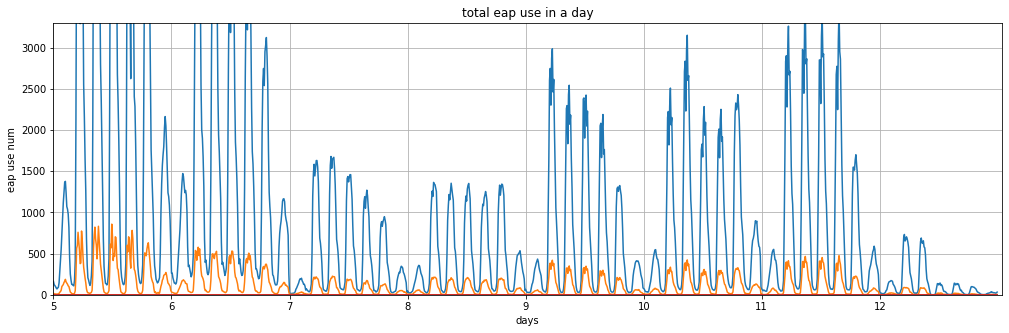

In [79]:
plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,3300)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(total_yoil_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

## 5) VLAN ID

In [80]:
data[('Client','VLAN ID')].unique()

array([17, 19, 20,  4,  3])

In [81]:
data[('Client','VLAN ID')].value_counts()

17    2634582
19     569616
3          14
20          2
4           2
Name: (Client, VLAN ID), dtype: int64

In [82]:
v1 = change_to_df('Client','VLAN ID',17)
v2 = change_to_df('Client','VLAN ID',19)
v3 = change_to_df('Client','VLAN ID',2)
v4 = change_to_df('Client','VLAN ID',20)
v5 = change_to_df('Client','VLAN ID',4)

In [359]:
# v1_yoil = change_to_month(v1)
# v2_yoil = change_to_month(v2)
# v3_yoil = change_to_month(v3)
# v4_yoil = change_to_month(v4)
# v5_yoil = change_to_month(v5)

In [ ]:
total_yoil = pd.concat([v1_yoil,v2_yoil,v3_yoil,v4_yoil,v5_yoil], axis=1)

In [ ]:
total_yoil_temp = total_yoil.reset_index()

In [ ]:
total_yoil_temp.drop(['month','yoil','hour'], axis=1, inplace=True)

In [ ]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,3300)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(total_yoil_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

In [ ]:
data[('Client','VLAN ID')]

# 2-1 숫자데이터

In [85]:
def data_in_every_hour(col1, col2):
    
    val = data
    
    date = []
    yoil = []
    hour = []
    
    dic = {}
    
    i =0
    for time1,time2, target in zip( pd.to_datetime(val[('Association Time', 'time')]), pd.to_datetime(val[('Disassociation Time', 'time')]),val[(col1,col2)]  ):
        t1 = time1.hour 
        t2 = time2.hour #정확하게 associ 와 disassoci 의 차이를 통해

        for t in range(t1, t2+1):
            
            if t < 10:
                t = '0'+str(t)
            else: t = str(t)

            #secific_date
            
            d = time1.date()
            h = t
            
            secific_date =str(d)+" " +str(h)
            
            if secific_date in dic:
                dic[secific_date].append(target)
            else:
                dic[secific_date] = [target]
                    
    return dic


In [259]:
def num_dic_change_to_df(col1, col2):
    
    #몇시에 몇개있는지 함수 실행 - 딕셔너리 리턴
    res = data_in_every_hour(col1, col2)
    
    #딕셔너리 -> 평균내기
    
    for each in res:
        res[each] = (sum(res[each]),len(res[each]))
    
    #딕셔너리 키(날짜-시간)로 소팅
    sorted_res = sorted(res.keys())
    
    date = []
    yoil = []
    hour = []
    df = []
    num = []
    
    #첫날, 마지막날
    firstday = "2019-05-19"
    lastday = "2019-12-31"

    daterange = pd.date_range(start = firstday, end = lastday)
    hourrange = ["0"+str(x)  if x < 10 else str(x) for x in range(0,24)]

    for d in daterange:
        for h in hourrange:
            each_day = str(d.date()) + " " + str(h)
            if each_day in res:
                date.append(str(d.date()))
                yoil.append(d.day_name())
                hour.append(h)
                df.append(res[each_day][0])
                num.append(res[each_day][1])  
            else:
                date.append(str(d.date()))
                yoil.append(d.day_name())
                hour.append(h)
                df.append(0)
                num.append(0)
        
    series = pd.Series(df, index = [date,yoil,hour,num])
    ret_df = pd.DataFrame(series)
    
    ret_df.index.names = ["date",'yoil',"hour","cnt"]
    ret_df.columns = [col2]
   
    return ret_df

In [277]:
def change_to_month(yoso_df):
    month=[]
    yoil=[]
    hour=[]
    df=[]
    for monthNum in range(5,13):
        m=""
        d=30

        # 월에 10보다작으면 0붙이기
        if monthNum <10:
            m = "0"+str(monthNum)
        else:
            m = str(monthNum)

        #5,7,8,10,12,월은 31일까지있음
        if monthNum in [5,7,8,10,12]:
            d = 31

       #5월은 19일부터시작
        if monthNum==5:
            firstday = "2019-" + m+"-19"
        else:
            firstday = "2019-" + m+"-01"

        lastday = "2019-"+m+"-"+str(d)

        hourrange = ["0"+str(x)  if x < 10 else str(x) for x in range(0,24)]
        daterange = pd.date_range(start = firstday, end = lastday)
        weeks = ["Sunday","Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday"]



        for week in weeks:
            hcnt = {}
            hdiv = {}
            for d in daterange:

                if d.day_name() == week:
                    for h in hourrange:

                        if h in hcnt:
                            hcnt[h] += yoso_df.loc[(str(d.date()),week,h)][0]

                        else:
                            hcnt[h] = yoso_df.loc[(str(d.date()),week,h)][0]

                        if h in hdiv:
                            hdiv[h]+= 1
                        else:
                            hdiv[h] = yoso_df.loc[(str(d.date()),week,h)][1]


            #나누기 평균
            newcnt={}
            for k1,k2 in zip(hcnt,hdiv):
                newcnt[k1] = hcnt[k1] / hcnt[k2]
                

            #원소붙이기
            for k in hcnt:
                hour.append(k)
                df.append(hcnt[k])
                yoil.append(week)
                month.append(monthNum)


    series = pd.Series(df,index = [month,yoil,hour])
    ret_df = pd.DataFrame(series)    

    ret_df.index.names = ["month",'yoil',"hour"]
    ret_df.columns = [yoso_df.columns[0]]

    return ret_df
        

In [260]:
throughput = num_dic_change_to_df('Utilization',"Avg. Session Throughput (Kbps)")

In [273]:
throughput.reset_index(level=3, inplace=True)

In [278]:
throughput_temp = change_to_month(throughput)

In [279]:
throughput_temp

cnt
month yoil     hour       
5     Sunday   00    363.0
               01    275.0
               02    242.0
               03    220.0
               04    180.0
...                    ...
12    Saturday 19    113.0
               20    102.0
               21     89.0
               22    111.0
               23    147.0

[1344 rows x 1 columns]

In [281]:
throughput_temp = throughput_temp.reset_index()

In [282]:
throughput_temp.drop(['month','yoil','hour'], axis=1, inplace=True)

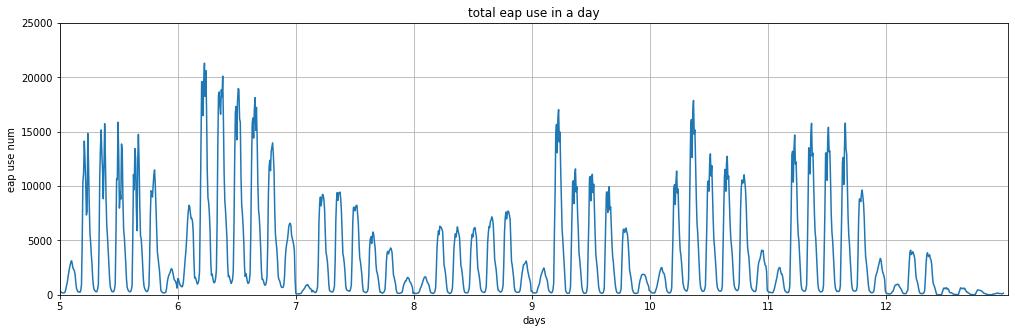

In [294]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,25000)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(throughput_temp)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

# Data Retries

In [309]:
Data_Retries = num_dic_change_to_df('Utilization',"Data Retries")

In [310]:
Data_Retries.reset_index(level=3, inplace=True)

In [311]:
data_retries = change_to_month(Data_Retries)

In [312]:
data_retries = data_retries.reset_index()

In [313]:
data_retries.drop(['month','yoil','hour'], axis=1, inplace=True)

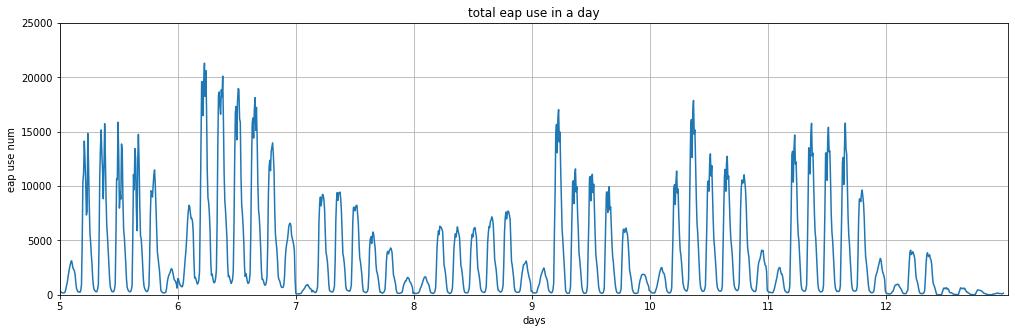

In [314]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,25000)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(data_retries)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

# RSSI (dBm)

In [328]:
RSSI = num_dic_change_to_df('Utilization',"RSSI (dBm)")

In [329]:
RSSI.reset_index(level=3, inplace=True)

In [330]:
rssi = change_to_month(RSSI)

In [339]:
rssi = rssi.reset_index()

In [352]:
rssi.drop(['month','yoil','hour'], axis=1, inplace=True)

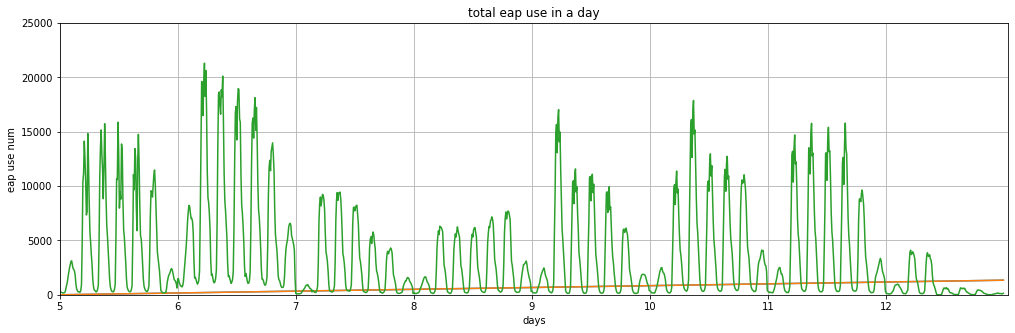

In [351]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,25000)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(rssi)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

# RTS Retries

In [333]:
RTS_Retries = num_dic_change_to_df('Utilization',"RTS Retries")

In [334]:
RTS_Retries.reset_index(level=3, inplace=True)

In [335]:
rts = change_to_month(RTS_Retries)

In [336]:
rts = rts.reset_index()

In [337]:
rts.drop(['month','yoil','hour'], axis=1, inplace=True)

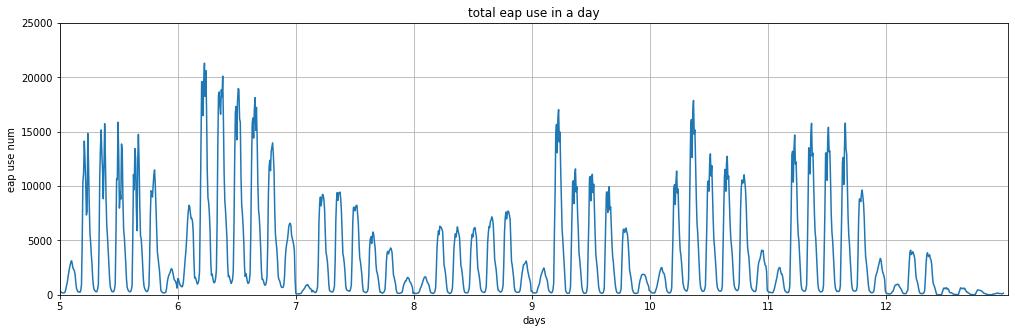

In [338]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,25000)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(rts)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

# SNR (dB)

In [345]:
SNR = num_dic_change_to_df('Utilization',"SNR (dB)")

In [346]:
SNR.reset_index(level=3, inplace=True)

In [347]:
snr = change_to_month(SNR)

In [348]:
snr = snr.reset_index()

In [349]:
snr.drop(['month','yoil','hour'], axis=1, inplace=True)

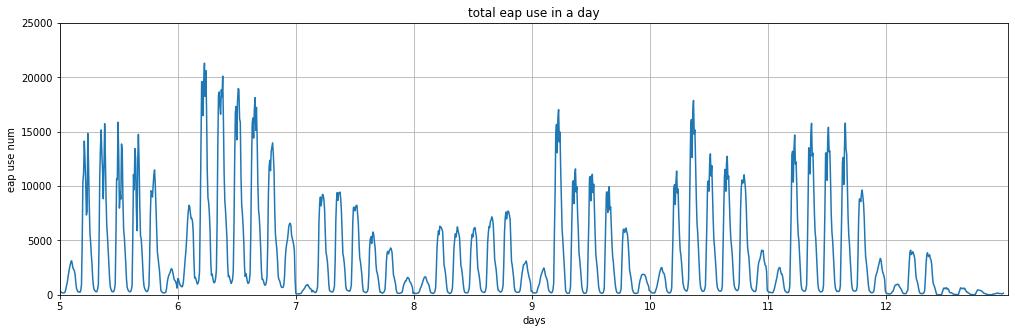

In [350]:
##### plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,25000)
plt.xlim(500,1350)
plt.xticks([0,168,168*2,168*3,168*4,168*5,168*6,168*7],[5,6,7,8,9,10,11,12])
plt.plot(snr)
plt.title('total eap use in a day')
plt.xlabel('days')
plt.ylabel('eap use num')
plt.grid()

# 3. AP 별로 주기가 있는 칼럼 찾아내기

In [ ]:
data[('Client','Protocol')].unique()